## change-prediction-on-favela-boundary

using LSTM model to predict boundary change
1. Option1: Using masks (tile data for deep learning) to build LSTM models
2. Option2: Using coordinate point data to build LSTM model (not in use)

### Option 1: Using masks (tile data for deep learning) to build LTSM models

In [3]:
import cv2
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import MeanIoU

from tensorflow.keras.models import load_model
from tensorflow.image import resize

In [16]:
import rasterio
def read_tif(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1)  # 读取单波段数据

# 假设你有文件夹路径
folder_1999 = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[1999]'
folder_2008 = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2008]_matched_files'
folder_2013 = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2013to2019]'
folder_2019 = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2019to2024]_matched_files'

# 获取每个文件夹中的文件名列表（假设文件名为 .tif 格式）
files_1999 = set(os.listdir(folder_1999)) 
files_2008 = set(os.listdir(folder_2008))  
files_2013 = set(os.listdir(folder_2013))  
files_2019 = set(os.listdir(folder_2019))  

# 取交集：找出每个文件夹中都存在的文件
common_files = files_1999.intersection(files_2008).intersection(files_2013).intersection(files_2019)

# 如果只想保留.tif文件，可以过滤
common_files = {f for f in common_files if f.endswith('.tif')}

# # # 读取每年的图像并存储
masks_1999 = [read_tif(f"{folder_1999}/{name}") for name in common_files]
masks_2008 = [read_tif(f"{folder_2008}/{name}") for name in common_files]
masks_2013 = [read_tif(f"{folder_2013}/{name}") for name in common_files]
masks_2019 = [read_tif(f"{folder_2019}/{name}") for name in common_files]


In [17]:
masks_1999[0].shape

# type(masks_1999[0])

# np.unique(masks_1999[0])

(1024, 1024)

In [18]:
# 调整掩码图像大小到 256x256
def resize_masks(masks, size=(128, 128)):
    resized_masks = [cv2.resize(mask, size) for mask in masks]
    return resized_masks

target_size=(128, 128)

masks_1999_resized = resize_masks(masks_1999, target_size)
masks_2008_resized = resize_masks(masks_2008, target_size)
masks_2013_resized = resize_masks(masks_2013, target_size)
masks_2019_resized = resize_masks(masks_2019, target_size)

masks_1999_resized[0].shape

(128, 128)

In [19]:
# 将每年的掩码数据拍平
masks_1999_flat = [mask.flatten() for mask in masks_1999_resized]
masks_2008_flat = [mask.flatten() for mask in masks_2008_resized]
masks_2013_flat = [mask.flatten() for mask in masks_2013_resized]
masks_2019_flat = [mask.flatten() for mask in masks_2019_resized]

In [8]:
# 构建时间序列数据 (samples, timesteps, features)
X = np.array([masks_1999_flat, masks_2008_flat, masks_2013_flat]).transpose(1, 0, 2)  # 转置为 (num_samples, 3, pixel*pixel)

# 假设 Y 是 2030 年的目标掩码（需要将其拍平）
y = np.array(masks_2019_flat)

# 保存 X 和 y 到 .npy 文件
np.save(f'X_{target_size[0]}.npy', X)
np.save(f'y_{target_size[0]}.npy', y)

In [1]:
import tensorflow as tf
print(tf.__version__)

3.7.0


In [4]:
X = np.load('X_128.npy')
y = np.load('y_128.npy')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((1045, 3, 16384), (1045, 16384))

In [38]:
# np.unique(y)

array([0, 1], dtype=uint16)

In [7]:
# 创建 LSTM 模型
model = Sequential()

# 添加 LSTM 层，units 是 LSTM 单元的数量
model.add(LSTM(units=64, activation='relu', input_shape=(X.shape[1], X.shape[2])))  

# 输出层，输出与输入掩码相同的形状
model.add(Dense(units=X.shape[2], activation='sigmoid')) 

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
            #   loss='mean_squared_error'

# 查看模型架构
model.summary()


d:\Software\Anaconda3\envs\pytorch\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │     4,210,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16384)          │     1,064,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,275,904 (20.13 MB)

 Trainable params: 5,275,904 (20.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 创建日志目录
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # 监控验证损失
    patience=3,          # 如果验证损失在3个epoch内没有改善，则停止训练
    restore_best_weights=True  # 恢复训练过程中表现最好的模型权重
)

In [10]:
# 训练模型并显示训练进度
model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=1, callbacks=[tensorboard_callback, early_stopping_callback, checkpoint])

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.5589 - mean_io_u: 0.4321 - val_loss: 0.3061 - val_mean_io_u: 0.4218
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2759 - mean_io_u: 0.4270 - val_loss: 0.2278 - val_mean_io_u: 0.4218
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1819 - mean_io_u: 0.4280 - val_loss: 0.2050 - val_mean_io_u: 0.4218
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1525 - mean_io_u: 0.4297 - val_loss: 0.1867 - val_mean_io_u: 0.4218
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1416 - mean_io_u: 0.4257 - val_loss: 0.1815 - val_mean_io_u: 0.4218
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1336 - mean_io_u: 0.4276 - val_loss: 0.1790 - val_mean_io_u: 0.4218
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.1249 - mean_io_u: 0.4303 - val_loss: 0.1729 - val_mean_io_u: 0.4218
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.1114 - mean_

In [59]:
model.save('my_model.keras')  # how to save the best model

In [21]:
model = load_model('my_model.keras')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                4210944   
                                                                 
 dense_5 (Dense)             (None, 16384)             1064960   
                                                                 
Total params: 5275904 (20.13 MB)
Trainable params: 5275904 (20.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
# 启动 TensorBoard
%tensorboard --logdir=logs

UsageError: Line magic function `%tensorboard` not found.


In [12]:
target_size = (128, 128)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


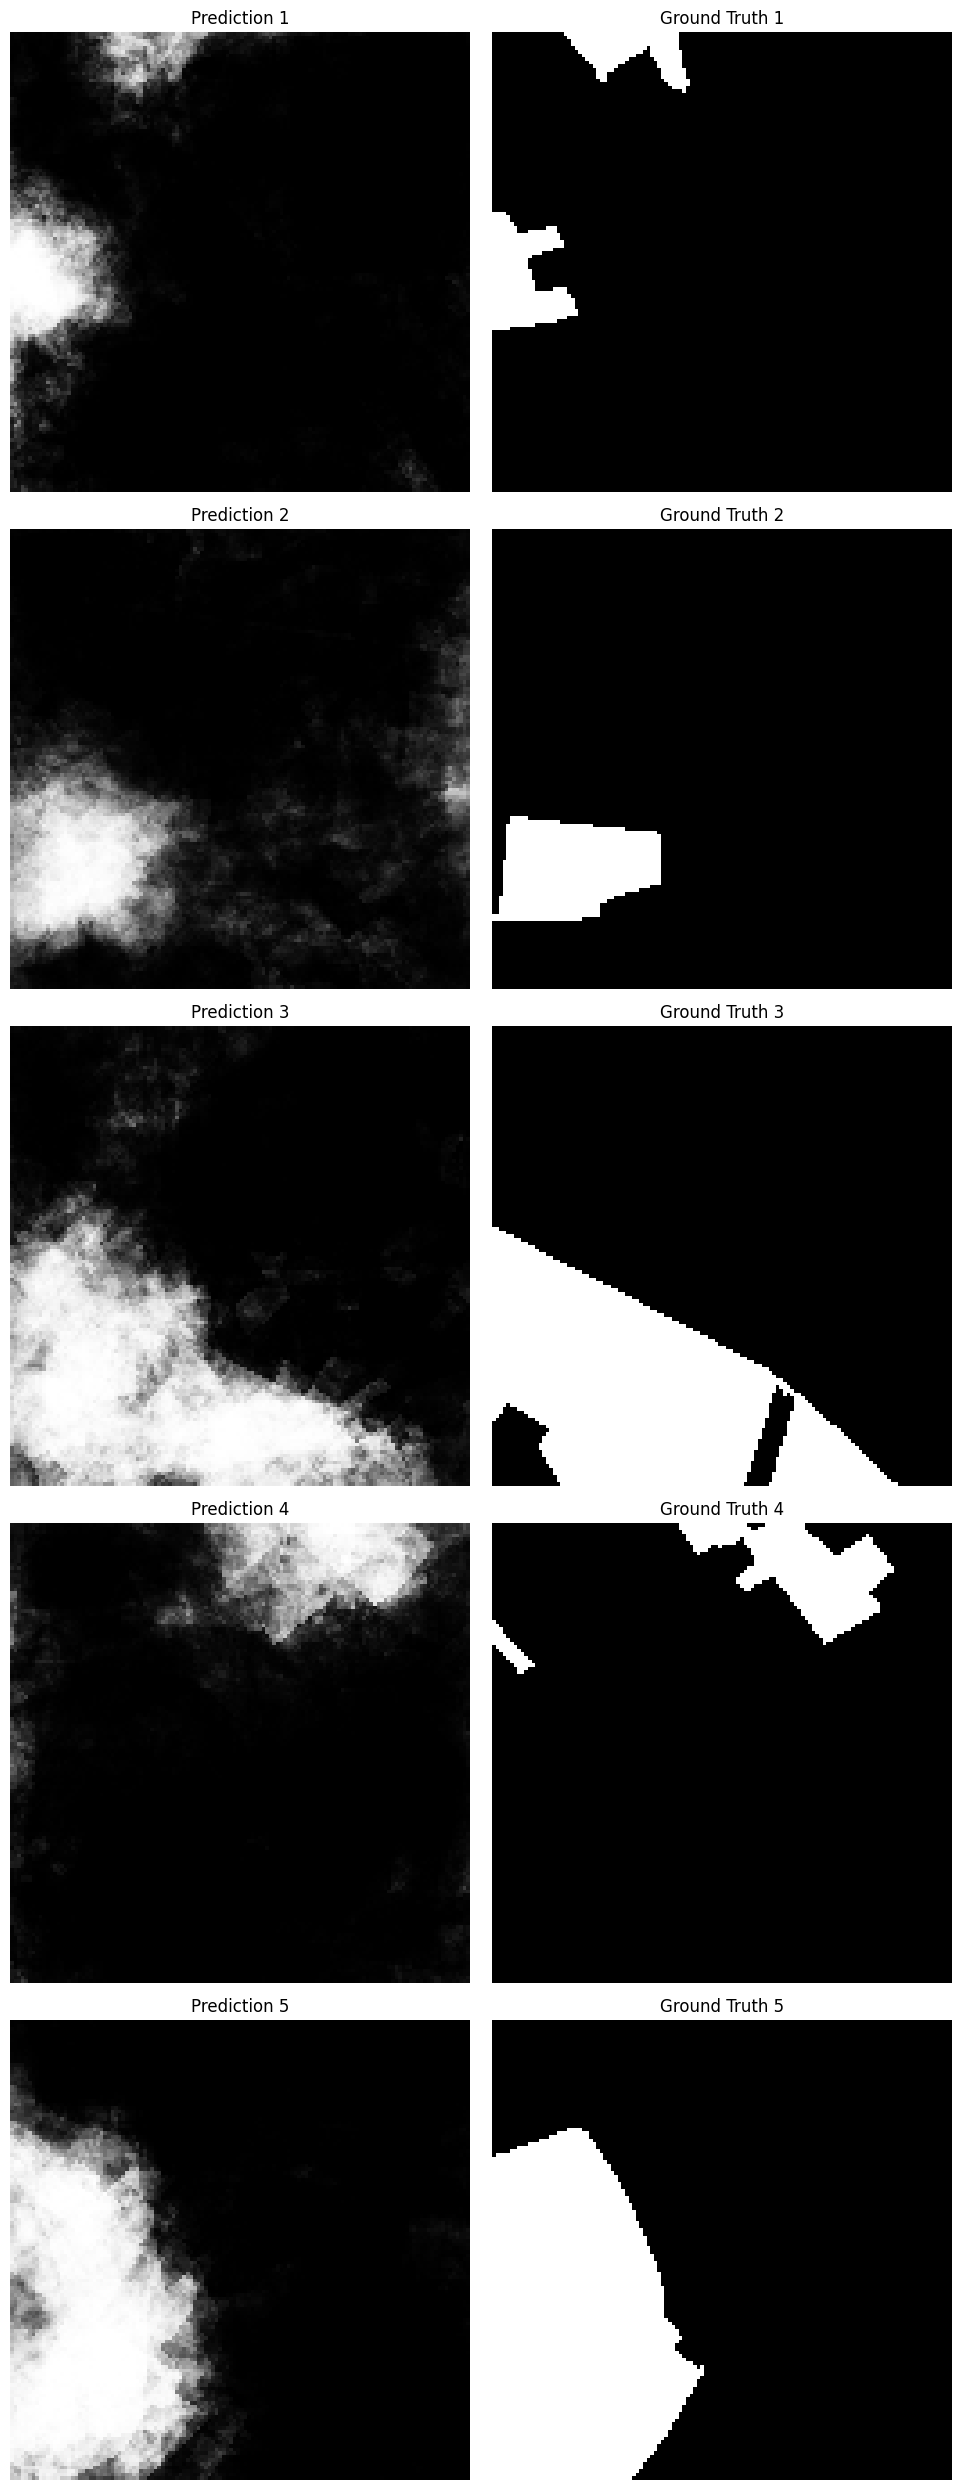

In [13]:
num_samples = 5
X_samples = X_test[:num_samples]
y_samples = y_test[:num_samples]

# 进行预测
predictions = model.predict(X_samples)

# 将预测结果和真实标签调整为target_size的大小
predictions_resized = np.array([resize(pred.reshape(target_size[0], target_size[1], 1), target_size).numpy().squeeze() for pred in predictions])
y_samples_resized = np.array([resize(y.reshape(target_size[0], target_size[1], 1), target_size).numpy().squeeze() for y in y_samples])

# 绘制比较图
fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

for i in range(num_samples):
    # 绘制预测结果
    axes[i, 0].imshow(predictions_resized[i], cmap='gray')
    axes[i, 0].set_title(f'Prediction {i+1}')
    axes[i, 0].axis('off')
    
    # 绘制真实标签
    axes[i, 1].imshow(y_samples_resized[i], cmap='gray')
    axes[i, 1].set_title(f'Ground Truth {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

prediction

In [20]:
# 使用训练好的模型预测2024年的数据
X_input = np.array([masks_2008_flat, masks_2013_flat, masks_2019_flat]).transpose(1, 0, 2)
y_2024_pred = model.predict(X_input)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


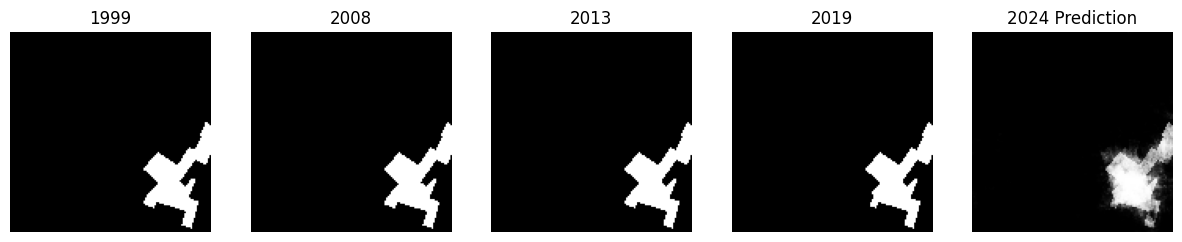

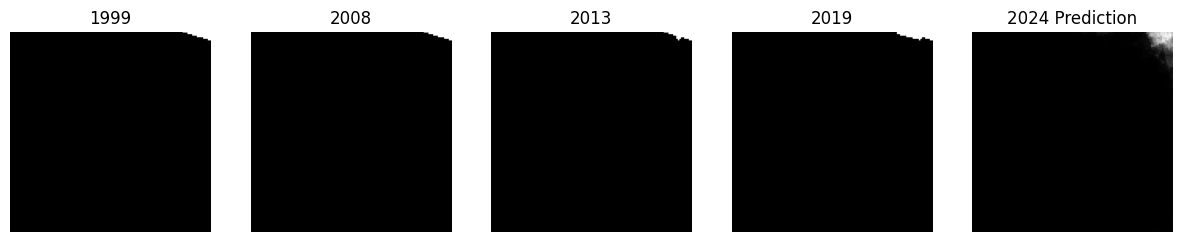

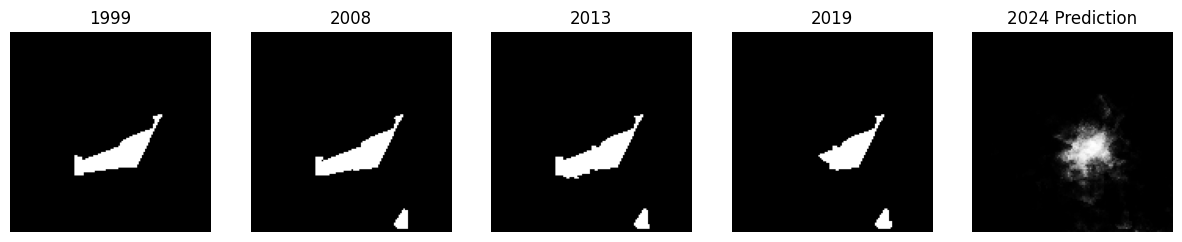

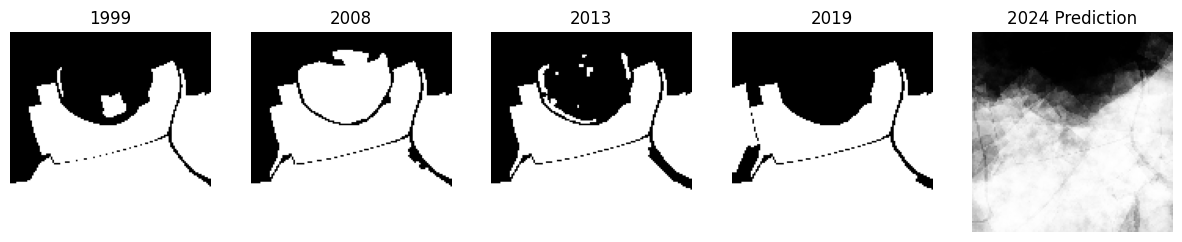

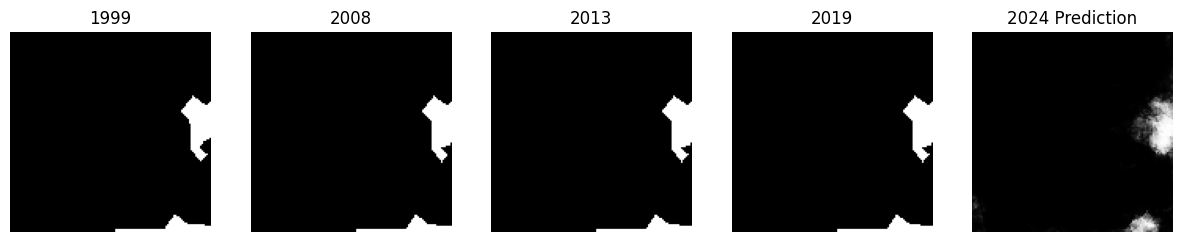

In [21]:
# 可视化结果
def visualize_masks(masks, titles):
    fig, axes = plt.subplots(1, len(masks), figsize=(15, 5))
    for ax, mask, title in zip(axes, masks, titles):
        ax.imshow(mask.reshape(target_size), cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()

for i in range(5):
    visualize_masks(
        [masks_1999_resized[i], masks_2008_resized[i], masks_2013_resized[i], masks_2019_resized[i], y_2024_pred[i].reshape(target_size)],
        ['1999', '2008', '2013', '2019', '2024 Prediction']
    )

In [29]:
import matplotlib
matplotlib.use('Agg')

In [30]:
# 创建保存预测结果的文件夹
output_dir = 'predictions'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 对所有数据进行预测并保存到文件夹
for i in range(len(masks_1999_resized)):
    # 调用 visualize_masks 函数进行预测
    visualize_masks(
        [masks_1999_resized[i], masks_2008_resized[i], masks_2013_resized[i], masks_2019_resized[i], y_2024_pred[i].reshape(target_size)],
        ['1999', '2008', '2013', '2019', '2024 Prediction']
    )

    plt.savefig(os.path.join(output_dir, f'prediction_{i}.png'))
    plt.clf()

C:\Users\YANGRUYI\AppData\Local\Temp\ipykernel_29404\2398955372.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\YANGRUYI\AppData\Local\Temp\ipykernel_29404\2398955372.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(masks), figsize=(15, 5))


### Option 2: Using coordinate point data to build LTSM model (not in use)

In [19]:
import pandas as pd
import ast

# 读取 CSV 文件
df = pd.read_csv('../output_directory/merged_favela.csv')

# 将坐标列转换为 Python 对象（从字符串解析为列表）
coordinate_columns = ["coordinates_1999", "coordinates_2008", "coordinates_2013", "coordinates_2019"]
for col in coordinate_columns:
    df[col] = df[col].apply(ast.literal_eval)

df.head()

,cod_favela,coordinates_1999,coordinates_2008,coordinates_2013,coordinates_2019
0,6,"[(682386.1456000004, 7468781.0183), (682396.54...","[(682386.1456000004, 7468781.0183), (682396.54...","[(682386.1456000004, 7468781.0183), (682396.54...","[(682386.1456000004, 7468781.0183), (682396.54..."
1,7,"[(685046.3103999998, 7466006.717), (685027.662...","[(685046.3103999998, 7466006.717), (685027.662...","[(685046.3103, 7466006.717), (685027.662600000...","[(685046.3103999998, 7466006.717), (685043.770..."
2,8,"[(683565.0186999999, 7469278.1371), (683559.85...","[(683565.0186999999, 7469278.1371), (683559.85...","[(683565.0186999999, 7469278.1372), (683559.85...","[(683565.0186999999, 7469278.1372), (683559.85..."
3,10,"[(683043.3461999996, 7463697.5759), (683059.36...","[(683043.3461999996, 7463697.5759), (683059.36...","[(683043.3463000003, 7463697.5759), (683059.36...","[(683043.3461999996, 7463697.5759), (683059.36..."
4,11,"[(684181.6815, 7464316.0825), (684198.59420000...","[(684181.6815, 7464316.0825), (684192.61500000...","[[(684218.2818, 7463970.3534), (684220.2285000...","[(684234.9967999998, 7463968.768), (684237.123..."


In [40]:
type(df['coordinates_2013'].iloc[4])

list

In [51]:
# x = df['coordinates_2013'].iloc[0]
x = df['coordinates_2013'].iloc[4]
len(x)

2

In [32]:
# def remove_outer_brackets(nested_list):
#     """
#     如果列表是嵌套的单个列表，则删除最外层的括号。
#     参数:
#         nested_list (list): 可能是嵌套的列表。
#     返回:
#         list: 删除最外层括号后的列表。
#     """
#     if isinstance(nested_list, list) and len(nested_list) == 1 and isinstance(nested_list[0], list):
#         return nested_list[0]
#     return nested_list

# # 删除最外层的括号
# for col in coordinate_columns:
#     df[col] = df[col].apply(remove_outer_brackets)

# df.head()

,cod_favela,coordinates_1999,coordinates_2008,coordinates_2013,coordinates_2019
0,6,"[(682386.1456000004, 7468781.0183), (682396.54...","[(682386.1456000004, 7468781.0183), (682396.54...","[(682386.1456000004, 7468781.0183), (682396.54...","[(682386.1456000004, 7468781.0183), (682396.54..."
1,7,"[(685046.3103999998, 7466006.717), (685027.662...","[(685046.3103999998, 7466006.717), (685027.662...","[(685046.3103, 7466006.717), (685027.662600000...","[(685046.3103999998, 7466006.717), (685043.770..."
2,8,"[(683565.0186999999, 7469278.1371), (683559.85...","[(683565.0186999999, 7469278.1371), (683559.85...","[(683565.0186999999, 7469278.1372), (683559.85...","[(683565.0186999999, 7469278.1372), (683559.85..."
3,10,"[(683043.3461999996, 7463697.5759), (683059.36...","[(683043.3461999996, 7463697.5759), (683059.36...","[(683043.3463000003, 7463697.5759), (683059.36...","[(683043.3461999996, 7463697.5759), (683059.36..."
4,11,"[(684181.6815, 7464316.0825), (684198.59420000...","[(684181.6815, 7464316.0825), (684192.61500000...","[[(684218.2818, 7463970.3534), (684220.2285000...","[(684234.9967999998, 7463968.768), (684237.123..."


In [ ]:
def prepare_polygon_data(data, sequence_length=3):
    """
    准备多边形坐标的时序数据。
    参数:
        data (list): 每个时间点的多边形坐标列表。
        sequence_length (int): 输入的时间序列长度。
    返回:
        X, y: 输入和目标数据。
    """
    scaler = MinMaxScaler()
    scaled_data = [scaler.fit_transform(coords) for coords in data]
    
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length])
        y.append(scaled_data[i + sequence_length])
    
    return np.array(X), np.array(y), scaler

# 示例多边形数据
polygon_data = [
    np.array([[0, 0], [1, 0], [1, 1], [0, 1]]),  # 2000 年的多边形
    np.array([[0, 0], [1.1, 0], [1.1, 1.1], [0, 1.1]]),  # 2010 年
    np.array([[0, 0], [1.2, 0], [1.2, 1.2], [0, 1.2]])   # 2020 年
]

# 准备数据
X, y, scaler = prepare_polygon_data(polygon_data, sequence_length=2)
print("输入数据形状:", X.shape)
print("目标数据形状:", y.shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

# 构建模型
def build_polygon_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32, return_sequences=False),
        Dense(input_shape[-2] * input_shape[-1]),  # 输出顶点的坐标
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 模型输入形状: (时间步长, 顶点数, 坐标维度)
input_shape = X.shape[1:]
model = build_polygon_lstm(input_shape)

# 训练模型
model.fit(X, y.reshape(y.shape[0], -1), epochs=50, batch_size=16, validation_split=0.2)

# 预测
predicted = model.predict(X)
predicted_coords = predicted.reshape(predicted.shape[0], -1, 2)
